# set things up; imports and data loading

In [67]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os

tqdm.pandas()

In [68]:
DATA_PATH = "/data/laviniad/congress_errata/classed_congress_df.json"
df = pd.read_json(DATA_PATH)
df['date'] = pd.to_datetime(df['date'].apply(str), format='%Y%m%d')
df['month'] = df['date'].dt.month

In [69]:
raw_df = pd.read_json(DATA_PATH)

In [70]:
orig_len = len(df)

# filtering

In [71]:
def is_dem_rep(t):
    return (t == 'Democrat') or (t == 'Republican')

def not_procedural_unknown_topic(x):
    return (not ('Procedural' in x)) and (not ('Unknown' in x))

def is_long(x, thresh=5): # takes string, whitespace heuristic
    return len(x.split()) > thresh

def is_in_range(x):
    return x in range(1995, 2023)

df = df[df['party'].progress_apply(is_dem_rep)]
#df = df[df['main_topic'].progress_apply(not_procedural_unknown_topic)]
df = df[df['year'].progress_apply(is_in_range)]
df = df[df['text'].progress_apply(is_long)]

  0%|          | 0/1328805 [00:00<?, ?it/s]

  0%|          | 0/1203575 [00:00<?, ?it/s]

  0%|          | 0/1182286 [00:00<?, ?it/s]

In [72]:
print(f"Filtered out {orig_len - len(df)} rows")
print(f"New length: {len(df)}")

Filtered out 147411 rows
New length: 1181394


# transform data for regression

In [73]:
# add some features
from data.congress_utils import induce_gender

df = induce_gender(df)
df['general'] = df['num_general'] > 0
df['christian'] = df['num_christian'] > 0

In [74]:
df.columns

Index(['bio_id', 'congress_num', 'year', 'date', 'chamber', 'speaker', 'text',
       'month_code', 'month', 'gender', 'party', 'state', 'is_in_senate',
       'main_topic', 'is_abortion', 'is_immigration', 'is_christianity',
       'is_science_technology', 'is_health_insurance', 'enclosing_county',
       'perc_adherents', 'religion', 'is_republican', 'church_in_bio',
       'dw_nom_1', 'dw_nom_2', 'lexical', 'num_general', 'num_christian',
       'length', 'binary_lex', 'full_state', 'state_perc_white',
       'state_perc_black', 'god', 'bible', 'jesus', 'faith', 'pray',
       'old_lexical', 'old_num_general', 'old_num_christian', 'old_binary_lex',
       'lr_label_prop_religious', 'max_lr_prob', 'avg_lr_prob', 'general',
       'christian'],
      dtype='object')

In [75]:
# get if in south

state_region_df = pd.read_csv('/home/laviniad/projects/religion_in_congress/data/pol_data/censusstateregions.csv')
state_to_region = dict(zip(state_region_df['State Code'], state_region_df['Region']))

def infer_in_south(state):
    if state in state_to_region.keys():
        return (state_to_region[state] == 'South')
    else:
        return False
    
df['in_south'] = df['state'].apply(infer_in_south)

In [76]:
# aggregate to speaker-year and speaker
# note that the chamber assigned is just the first one they were in for the given year (shouldn't be an issue)

# filter out super infrequent speakers
df = df[df['length'] > 100]

speaker_year_df = df.groupby(['bio_id', 'year']).agg({'party': 'first', 'chamber': 'first', 'speaker': 'first', 'month': 'first', 'gender': 'first',
                                                      'general': 'sum', 'christian': 'sum', 'state': 'first', 'religion': 'first', 
                                                      'length': 'sum', 'dw_nom_1': 'first', 'dw_nom_2': 'first', 'in_south': 'first'
                                                      }).reset_index()
speaker_year_df['lexical'] = (speaker_year_df['general'] + speaker_year_df['christian']) / speaker_year_df['length']

speaker_df = df.groupby('bio_id').agg({'party': 'first', 'chamber': 'first', 'speaker': 'first', 'month': 'first', 'gender': 'first',
                                                      'general': 'sum', 'christian': 'sum', 'state': 'first', 'religion': 'first', 
                                                      'length': 'sum', 'dw_nom_1': 'first', 'dw_nom_2': 'first', 'in_south': 'first'
                                                      }).reset_index()                                         

In [77]:
import numpy as np

speaker_df['log_len'] = np.log(speaker_df['length'])
speaker_year_df['log_len'] = np.log(speaker_year_df['length'])

In [78]:
speaker_year_df['is_rep'] = (speaker_year_df['party'] == 'Republican').apply(lambda x: int(x)) # want 1s and 0s
speaker_df['is_rep'] = (speaker_df['party'] == 'Republican').apply(lambda x: int(x))

In [79]:
speaker_year_df['lexical'] = (speaker_year_df['general'] + speaker_year_df['christian']) / speaker_year_df['length']    
speaker_df['lexical'] = (speaker_df['general'] + speaker_df['christian']) / speaker_df['length']

In [80]:
speaker_year_df['is_man'] = (speaker_year_df['gender'] == 'M').apply(lambda x: int(x))
speaker_df['is_man'] = (speaker_df['gender'] == 'M').apply(lambda x: int(x))

In [81]:
speaker_year_df['in_south'] = speaker_year_df['in_south'].apply(lambda x: int(x))
speaker_df['in_south'] = speaker_df['in_south'].apply(lambda x: int(x))

In [82]:
speaker_year_df['in_house'] = speaker_year_df['chamber'].apply(lambda x: int(x == 'House'))
speaker_df['in_house'] = speaker_df['chamber'].apply(lambda x: int(x == 'House'))

# set palette

In [83]:
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=1.8, rc={'figure.figsize':(12,10)}, style='whitegrid')

# add age

In [105]:
import json

bioguide_file = "/data/laviniad/congress_bioguides.jsonlist"
bio_to_birth_year = {}

with open(bioguide_file, 'r') as f:
    for l in tqdm(f.readlines()):
        bio = json.loads(l)
        # get birthday
        if 'birthDate' in bio.keys():
            birth_date = bio['birthDate']
            # get bio_id
            bio_id = bio['usCongressBioId']
            # add to bio_to_birth_year
            bio_to_birth_year[bio_id] = int(birth_date[:4])
        else:
            family_name = bio['familyName']
            #print("For congressperson with last name ", family_name, " no birthdate found")

def get_age_in_year(bio_id, year):
    return year - bio_to_birth_year[bio_id]

  0%|          | 0/12968 [00:00<?, ?it/s]

In [106]:
# add to speaker_year_df
speaker_year_df['age'] = speaker_year_df.progress_apply(lambda x: get_age_in_year(x['bio_id'], x['year']), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 15096/15096 [00:00<00:00, 131250.23it/s]


<Axes: >

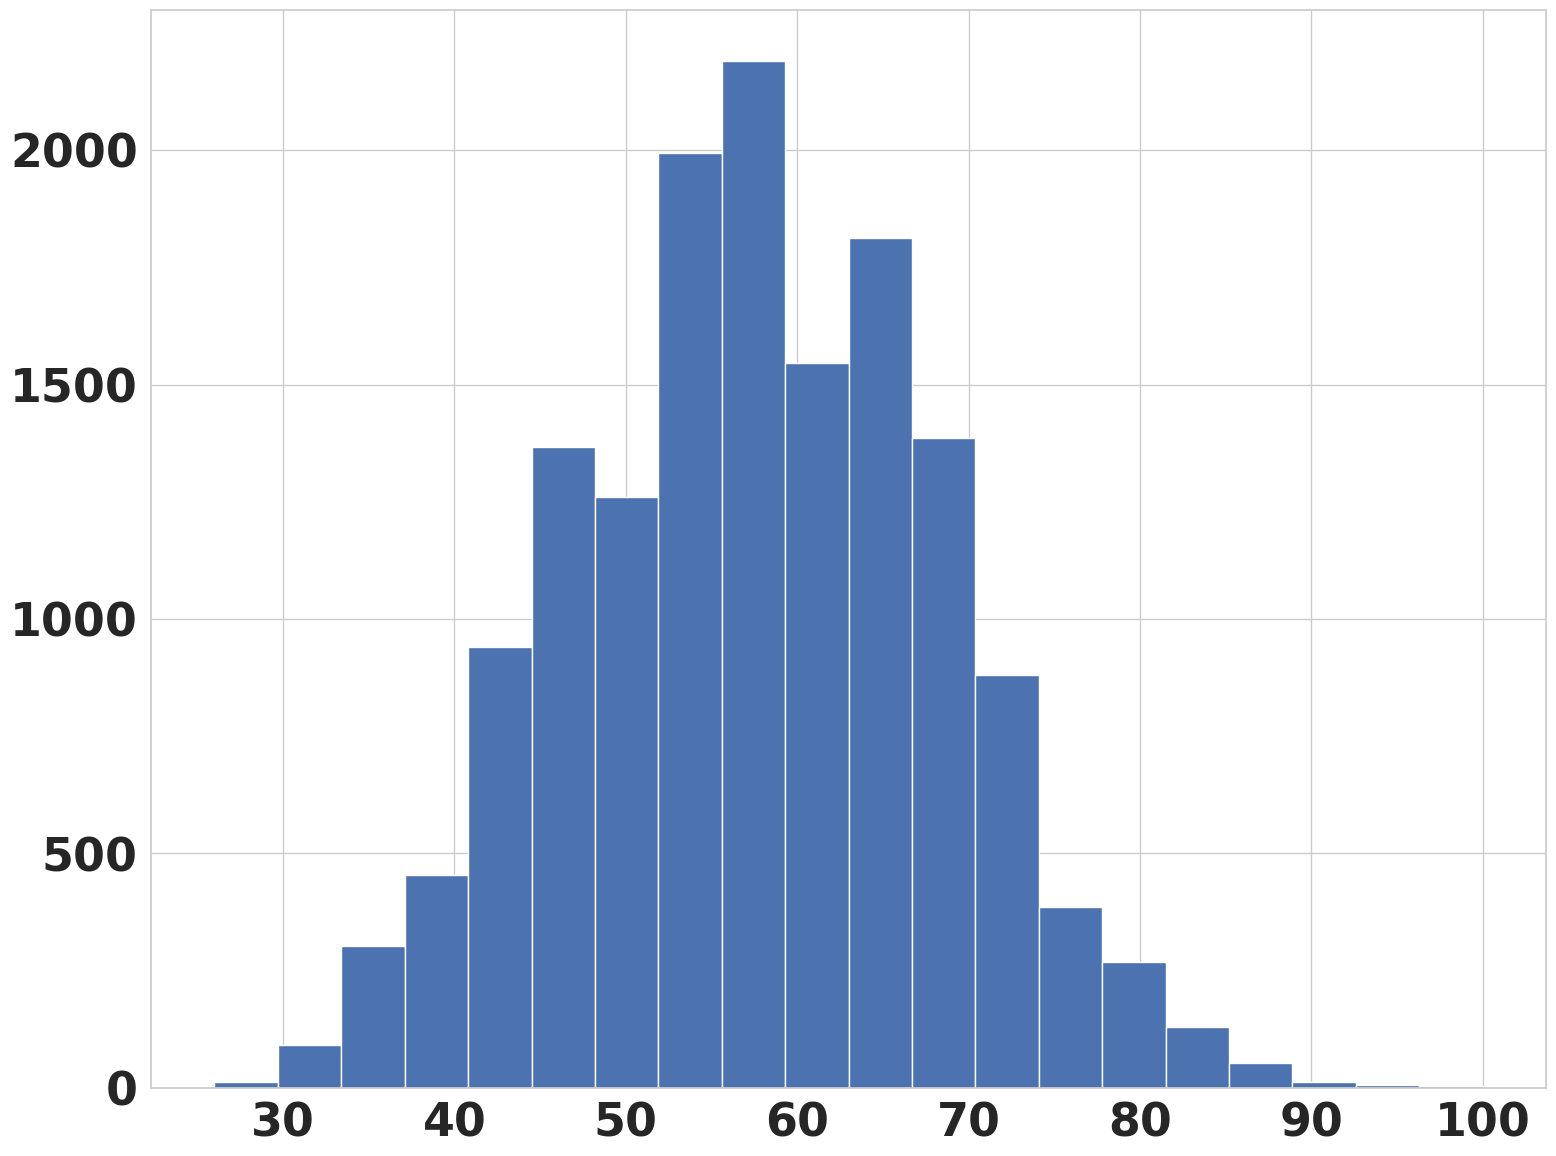

In [107]:
speaker_year_df['age'].hist(bins=20)

# regression

speaker-per-year regression

In [111]:
import statsmodels.api as sm

SUMMARY_OUTPUT_PATH = '/home/laviniad/projects/religion_in_congress/data/regression_summaries/'

# idx maps on to indices here:
different_input_var_combinations = [['is_rep', 'log_len'], ['is_rep', 'is_man', 'log_len'], ['is_rep', 'in_south', 'is_man', 'in_house', 'log_len']]
# might also switch to just first and last -- no iterative controls

for idx,c in enumerate(different_input_var_combinations):
    X = speaker_year_df[c]
    y = speaker_year_df['lexical'] > 0

    # Add a constant term to the independent variable
    X = sm.add_constant(np.asarray(X))

    # Fit the logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()

    # Print the summary of the logistic regression model
    print(result.summary())
    result.save(f'{SUMMARY_OUTPUT_PATH}logistic_regression_summary_{idx}.pkl')
    print(f"Saved model to {SUMMARY_OUTPUT_PATH}logistic_regression_summary_{idx}.pkl")

Optimization terminated successfully.
         Current function value: 0.554900
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                lexical   No. Observations:                15096
Model:                          Logit   Df Residuals:                    15093
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Jul 2024   Pseudo R-squ.:                  0.1353
Time:                        21:00:23   Log-Likelihood:                -8376.8
converged:                       True   LL-Null:                       -9687.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.1495      0.197    -41.427      0.000      -8.535      -7.764
x1             0.5006      0.

In [103]:
# for each year, create model; save coefficients and standard errors to df

model_attribute_df = []
c = ['is_rep', 'in_south', 'is_man', 'in_house', 'log_len']

for year in range(1995, 2023):
    sy = speaker_year_df[speaker_year_df['year'] == year]
    X = sy[c]
    y = sy['lexical'] > 0

    # Add a constant term to the independent variable
    X = sm.add_constant(np.asarray(X))

    # Fit the logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()

    # Print the summary of the logistic regression model
    model_attribute_df.append(result.params)

model_attribute_df = pd.DataFrame(model_attribute_df)

Optimization terminated successfully.
         Current function value: 0.501538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477367
  

In [ ]:
# plot coefficients over time

# rename columns and drop const
#model_attribute_df.drop('const', axis=1, inplace=True)
model_attribute_df.columns = c
model_attribute_df.drop('log_len', axis=1, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
model_attribute_df.plot(ax=ax)
ax.set_title('Coefficient Estimates Over Time')
ax.set_ylabel('Coefficient')
ax.set_xlabel('Year')
plt.savefig('/home/laviniad/projects/religion_in_congress/data/figures/coefficient_estimates_over_time.png')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
temp_df = model_attribute_df.rolling(window=3).mean()
temp_df.plot(ax=ax)
ax.set_title('Coefficient Estimates Over Time')
ax.set_ylabel('Coefficient')
ax.set_xlabel('Year')
plt.savefig('/home/laviniad/projects/religion_in_congress/data/figures/coefficient_estimates_over_time.png')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 ax.set_title('Odds Ratio Estimates Over Time')                                               │
│   5 ax.set_ylabel('OR')                                                                          │
│   6 ax.set_xlabel('Year')                                                                        │
│ ❱ 7 plt.savefig('/home/laviniad/projects/religion_in_congress/data/figures/coefficient_estimates_over_     │
│   8                                                                                              │
│                                                                                                  │
│ /home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/matplotlib/pyplot.py:1119 in │
│ savefig                                                                                          │
│                                                                                                  │
│   1116 │   fig = gcf()                                                                           │
│   1117 │   # savefig default implementation has no return, so mypy is unhappy                    │
│   1118 │   # presumably this is here because subclasses can return?                              │
│ ❱ 1119 │   res = fig.savefig(*args, **kwargs)  # type: ignore[func-returns-value]                │
│   1120 │   fig.canvas.draw_idle()  # Need this if 'transparent=True', to reset colors.           │
│   1121 │   return res                                                                            │
│   1122                                                                                           │
│                                                                                                  │
│ /home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/matplotlib/figure.py:3390 in │
│ savefig                                                                                          │
│                                                                                                  │
│   3387 │   │   │   │   # set axes to be transparent                                              │
│   3388 │   │   │   │   for ax in self.axes:                                                      │
│   3389 │   │   │   │   │   _recursively_make_axes_transparent(stack, ax)                         │
│ ❱ 3390 │   │   │   self.canvas.print_figure(fname, **kwargs)                                     │
│   3391 │                                                                                         │
│   3392 │   def ginput(self, n=1, timeout=30, show_clicks=True,                                   │
│   3393 │   │   │      mouse_add=MouseButton.LEFT,                                                │
│                                                                                                  │
│ /home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/matplotlib/backend_bases.py: │
│ 2193 in print_figure                                                                             │
│                                                                                                  │
│   2190 │   │   │   │   # _get_renderer may change the figure dpi (as vector formats              │
│   2191 │   │   │   │   # force the figure dpi to 72), so we need to set it again here.           │
│   2192 │   │   │   │   with cbook._setattr_cm(self.figure, dpi=dpi):                             │
│ ❱ 2193 │   │   │   │   │   result = print_method(                                                │
│   2194 │   │   │   │   │   │   filename,                                                         │
│   2195 │   │   │   │   │   │   facecolor=facecolo

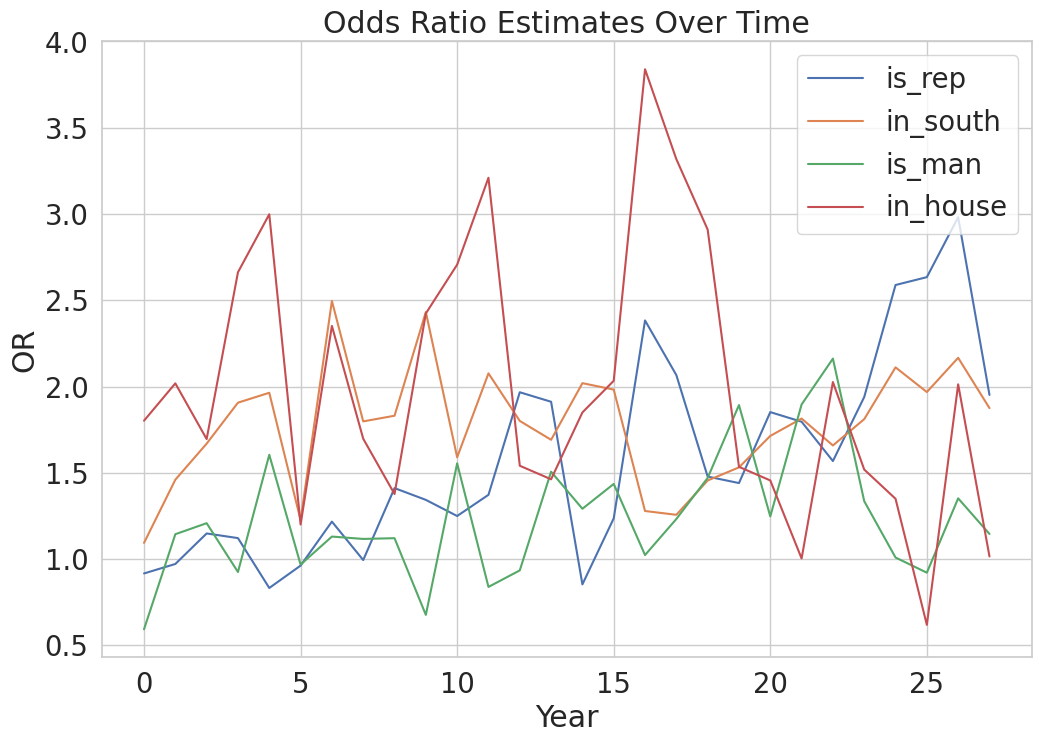

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
temp_df = np.exp(model_attribute_df)
temp_df.plot(ax=ax)
ax.set_title('Odds Ratio Estimates Over Time')
ax.set_ylabel('OR')
ax.set_xlabel('Year')
plt.savefig('/home/laviniad/projects/religion_in_congress/data/figures/coefficient_estimates_over_time.png')

In [85]:
# WITH YEAR random effect
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

for idx,c in enumerate(different_input_var_combinations):
    X = speaker_year_df[c]
    y = speaker_year_df['lexical'] > 0
    random_effects = pd.get_dummies(speaker_year_df['year'], drop_first=True)

    # Add a constant term to the independent variable
    X = sm.add_constant(np.asarray(X))
    ident = [1] * random_effects.shape[1]

    # Fit the logistic regression model
    model = BinomialBayesMixedGLM(y, X, random_effects, ident)
    result = model.fit_vb()

    # Print the summary of the logistic regression model
    print(result.summary())

/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")


            Binomial Mixed GLM Results
     Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------
FE_1    M    -1.5224   0.0056                      
FE_2    M     0.7298   0.0505                      
FE_3    M     0.3674   0.1438                      
VC_1    V     0.0000   0.6957 1.000   0.249   4.021
VC_2    V    -0.0402   0.5393 0.961   0.327   2.825
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations


/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")


            Binomial Mixed GLM Results
     Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------
FE_1    M    -0.4604   0.1273                      
FE_2    M     0.2774   0.2477                      
FE_3    M    -0.0653   0.1446                      
FE_4    M     0.1573   0.0642                      
VC_1    V     0.0000   0.6195 1.000   0.290   3.452
VC_2    V    -0.0098   0.5974 0.990   0.300   3.271
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations
            Binomial Mixed GLM Results
     Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------
FE_1    M    -1.5975   0.0051                      
FE_2    M    -0.1528   0.0604                      
FE_3    M     0.1253   0.1143                      
FE_4    M    -0.2832   0.0354                      
FE_5    M    -1.2938   0.0257                      
FE_6    M     0.6

/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/statsmodels/genmod/bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")


speaker regression

In [86]:
for idx,c in enumerate(different_input_var_combinations):
    X = speaker_df[c]
    y = speaker_df['lexical'] > 0

    # Add a constant term to the independent variable
    X = sm.add_constant(np.asarray(X))

    # Fit the logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()

    # Print the summary of the logistic regression model
    print(result.summary())
    result.save(f'{SUMMARY_OUTPUT_PATH}logistic_regression_summary_{idx}.pkl')
    print(f"Saved model to {SUMMARY_OUTPUT_PATH}logistic_regression_summary_{idx}.pkl")

Optimization terminated successfully.
         Current function value: 0.181872
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                lexical   No. Observations:                 1519
Model:                          Logit   Df Residuals:                     1516
Method:                           MLE   Df Model:                            2
Date:                Tue, 09 Jul 2024   Pseudo R-squ.:                  0.3300
Time:                        15:45:22   Log-Likelihood:                -276.26
converged:                       True   LL-Null:                       -412.32
Covariance Type:            nonrobust   LLR p-value:                 8.168e-60
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.2381      1.141    -10.727      0.000     -14.474     -10.002
x1             1.2395      0.

# load biblical reference data

In [88]:
# load BR df

import pickle as pkl
import re
from data.bible_utils import comp_bible_helper
import nltk

MPNET_RESULTS = '/data/laviniad/sermons-ir/modeling/mpnet_results'
with open(MPNET_RESULTS + "/data.pkl", "rb") as f:
    data = pkl.load(f)

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

bible_df = comp_bible_helper()
pop_verses = pd.read_csv('/home/laviniad/projects/religion_in_congress/data/most_popular_verses.csv')
n = 500 # VERY generous
pop_citations = list(pop_verses['verse'].iloc[1:n+1])
bible_df['King James Bible'] = bible_df['King James Bible'].apply(remove_tags) # KJV in this df has italics etc
bible_df['Verse'] = bible_df['Verse'].apply(lambda x: x.lower())
limited_bible_df = bible_df[bible_df['Verse'].apply(lambda x: x in pop_citations)]
limited_verses = limited_bible_df['King James Bible']
verse_df = [{'text': t['King James Bible'], 'citation': t['citation']} for idx,t in limited_bible_df.iterrows()]
verse_df = pd.DataFrame(verse_df)
print(f"Number of verses: {len(verse_df.index)}")
limited_verse_to_citation = dict(zip(limited_verses, limited_bible_df['Verse']))
limited_citation_to_verse = {v.lower(): k for k,v in limited_verse_to_citation.items()}

br_df = pd.read_csv(MPNET_RESULTS + '/results_NEW.csv')
br_df['congress_idx'] = br_df['congress_idx'].apply(lambda x: x.replace('tensor(', '').replace(')', '')).apply(int)

full_br_df = br_df.copy()
br_df = br_df[br_df['cosine_similarity'] > 0.8]

def get_year(congress_idx):
    if congress_idx in df.index:
        return df.loc[(congress_idx,'year')]
    else:
        return 'unlabeled'

br_df['year'] = br_df['congress_idx'].apply(get_year)

def get_party(congress_idx):
    if congress_idx in df.index:
        return df.loc[(congress_idx,'party')]
    else:
        return 'unlabeled'

br_df['party'] = br_df['congress_idx'].apply(get_party)

br_df['is_rep'] = (br_df['party'] == 'Republican').apply(int)

def get_speaker(congress_idx):
    idx_key = congress_idx
    if idx_key in df.index:
        speaker = df.loc[idx_key]['speaker']
        return speaker
    else:
        return 0

br_df['speaker'] = br_df['congress_idx'].progress_apply(get_speaker)

def get_date(congress_idx):
    idx_key = congress_idx
    if idx_key in df.index:
        speaker = df.loc[idx_key]['date']
        return speaker
    else:
        return 0

br_df['date'] = br_df['congress_idx'].progress_apply(get_date)

Number of verses: 499


  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

In [89]:
filtered_df = br_df[br_df['year'] != 'unlabeled']
filtered_df = filtered_df[filtered_df['speaker'] != 0]

In [95]:
len(filtered_df.index)

556

In [91]:
df.columns

Index(['bio_id', 'congress_num', 'year', 'date', 'chamber', 'speaker', 'text',
       'month_code', 'month', 'gender', 'party', 'state', 'is_in_senate',
       'main_topic', 'is_abortion', 'is_immigration', 'is_christianity',
       'is_science_technology', 'is_health_insurance', 'enclosing_county',
       'perc_adherents', 'religion', 'is_republican', 'church_in_bio',
       'dw_nom_1', 'dw_nom_2', 'lexical', 'num_general', 'num_christian',
       'length', 'binary_lex', 'full_state', 'state_perc_white',
       'state_perc_black', 'god', 'bible', 'jesus', 'faith', 'pray',
       'old_lexical', 'old_num_general', 'old_num_christian', 'old_binary_lex',
       'lr_label_prop_religious', 'max_lr_prob', 'avg_lr_prob', 'general',
       'christian', 'in_south'],
      dtype='object')

In [96]:
br_year_to_speaker = {}

def get_id_from_idx(idx):
    row = raw_df.loc[idx]

    if len(row.index) == 0:
        return 'unlabeled'
    else:
        return row['speaker']
    

for idx, row in tqdm(filtered_df.iterrows(), total=len(filtered_df)):
    if row['year'] not in br_year_to_speaker.keys():
        br_year_to_speaker[row['year']] = []
    br_year_to_speaker[row['year']].append(get_id_from_idx(row['congress_idx']))

  0%|          | 0/556 [00:00<?, ?it/s]

In [97]:
br_year_to_speaker

{2019: ['Mr. CASEY',
  'Mr. BYRNE',
  'Mr. GOHMERT',
  'Mr. GOHMERT',
  'Mr. GREEN of Texas',
  'Mrs. RODGERS of Washington',
  'Mr. LAMBORN',
  'Mr. BUDD',
  'Mr. GUEST',
  'Mr. GUEST',
  'Mr. GUEST'],
 2020: ['Mr. CLOUD',
  'Mr. DURBIN',
  'Mr. GRASSLEY',
  'Mr. DANNY K. DAVIS of Illinois',
  'Mrs. DEMINGS',
  'Mr. AUSTIN SCOTT of Georgia',
  'Mr. AUSTIN SCOTT of Georgia',
  'Mr. AUSTIN SCOTT of Georgia',
  'Mr. THOMPSON of Mississippi',
  'Mr. GOHMERT',
  'Mr. GOHMERT',
  'Mr. BABIN',
  'Mr. BACON',
  'Mr. LAMBORN',
  'Mr. LAMBORN',
  'Mr. MAST',
  'Mr. CUNNINGHAM',
  'Mr. MENENDEZ'],
 2009: ['Mr. SHULER',
  'Mr. SHULER',
  'Mr. SHULER',
  'Mr. SHULER',
  'Mr. SHULER',
  'Mr. POE of Texas',
  'Mr. FRANKS of Arizona',
  'Mr. CLEAVER',
  'Mr. ROHRABACHER',
  'Mr. KUCINICH',
  'Mr. INHOFE',
  'Mr. INHOFE'],
 2010: ['Mr. MILLER of North Carolina',
  'Ms. KAPTUR',
  'Mr. DODD',
  'Mr. ADERHOLT',
  'Mr. GOHMERT',
  'Mr. GOHMERT'],
 2021: ['Mr. CRIST',
  'Mr. STEUBE',
  'Ms. GARCIA of Texa

In [98]:
# add "referred to bible" boolean to speaker-year df and speaker-df

def referred_to_bible(row, year=None):
    if year:
        if str(row['speaker']) in br_year_to_speaker[year]:
            return True
        else:
            return False
    else:
        for year in br_year_to_speaker.keys():
            if row['speaker'] in br_year_to_speaker[year]:
                return True
        return False

speaker_year_df['referred_to_bible'] = speaker_year_df.progress_apply(lambda x: referred_to_bible(x, year=x['year']), axis=1)
speaker_df['referred_to_bible'] = speaker_df.progress_apply(lambda x: referred_to_bible(x), axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1519/1519 [00:00<00:00, 20793.36it/s]


In [109]:
speaker_year_df['referred_to_bible'].describe()

count     15096
unique        2
top       False
freq      14766
Name: referred_to_bible, dtype: object

In [112]:
import statsmodels.api as sm

SUMMARY_OUTPUT_PATH = '/home/laviniad/projects/religion_in_congress/data/regression_summaries/'

# idx maps on to indices here:
different_input_var_combinations = [['is_rep', 'log_len'], ['is_rep', 'is_man', 'log_len'], ['is_rep', 'in_south', 'is_man', 'in_house', 'log_len']]
# might also switch to just first and last -- no iterative controls

for idx,c in enumerate(different_input_var_combinations):
    X = speaker_year_df[c]
    y = speaker_year_df['referred_to_bible']

    # Add a constant term to the independent variable
    X = sm.add_constant(np.asarray(X))

    # Fit the logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()

    # Print the summary of the logistic regression model
    print(result.summary())
    result.save(f'{SUMMARY_OUTPUT_PATH}BR_logistic_regression_summary_{idx}.pkl')
    print(f"Saved model to {SUMMARY_OUTPUT_PATH}BR_logistic_regression_summary_{idx}.pkl")

Optimization terminated successfully.
         Current function value: 0.101582
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:      referred_to_bible   No. Observations:                15096
Model:                          Logit   Df Residuals:                    15093
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Jul 2024   Pseudo R-squ.:                 0.03432
Time:                        21:10:32   Log-Likelihood:                -1533.5
converged:                       True   LL-Null:                       -1588.0
Covariance Type:            nonrobust   LLR p-value:                 2.139e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1578      0.538    -17.014      0.000     -10.213      -8.103
x1             0.2839      0.

In [ ]:
for idx,c in enumerate(different_input_var_combinations):
    X = speaker_df[c]
    y = speaker_df['referred_to_bible']

    # Add a constant term to the independent variable
    X = sm.add_constant(np.asarray(X))

    # Fit the logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()

    # Print the summary of the logistic regression model
    print(result.summary())
    result.save(f'{SUMMARY_OUTPUT_PATH}BR_logistic_regression_summary_{idx}.pkl')
    print(f"Saved model to {SUMMARY_OUTPUT_PATH}BR_logistic_regression_summary_{idx}.pkl")